In [59]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [60]:
img = torchvision.io.read_image("ThomasShelby3.jpg")
print(img.shape)

torch.Size([3, 2048, 1365])


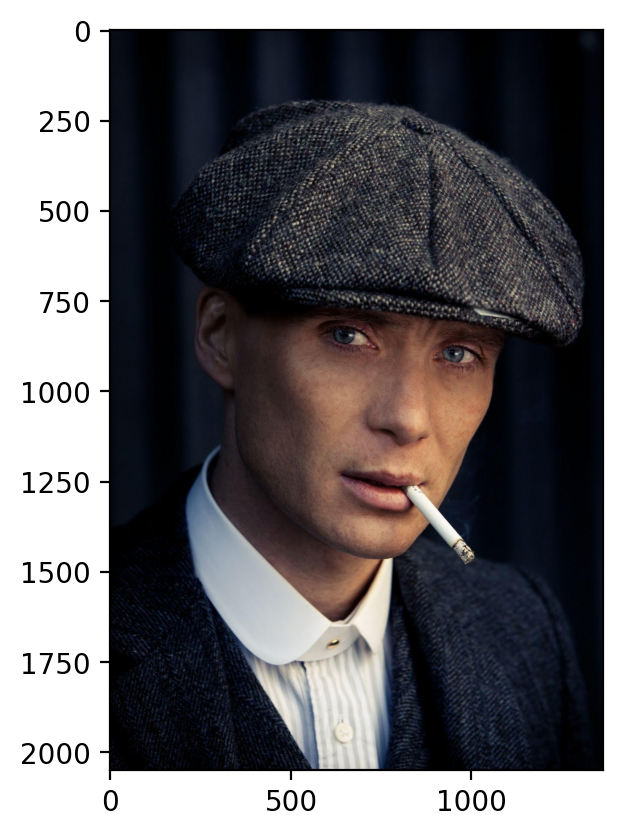

In [61]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [62]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [63]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [64]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
         [0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
         [0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0000, 0.0314, 0.0784,  ..., 0.0039, 0.0039, 0.0039],
         [0.0118, 0.0549, 0.0941,  ..., 0.0039, 0.0039, 0.0039],
         [0.0235, 0.0627, 0.0902,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0471, 0.0471, 0.0471,  ..., 0.0118, 0.0118, 0.0118],
         [0.0471, 0.0471, 0.0471,  ..., 0.0118, 0.0118, 0.0118],
         [0.0471, 0.0471, 0.0471,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0157, 0.0588, 0.1059,  ..., 0.0078, 0.0078, 0.0078],
         [0.0392, 0.0824, 0.1216,  ..., 0.0078, 0.0078, 0.0078],
         [0.0510, 0.0902, 0.1176,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0824, 0.0824, 0.0824,  ..., 0.0275, 0.0275, 0.0275],
         [0.0824, 0.0824, 0.0824,  ..., 0.0275, 0.0275, 0.0275],
         [0.0824, 0.0824, 0.0824,  ..., 0.0275, 0.0275, 0.

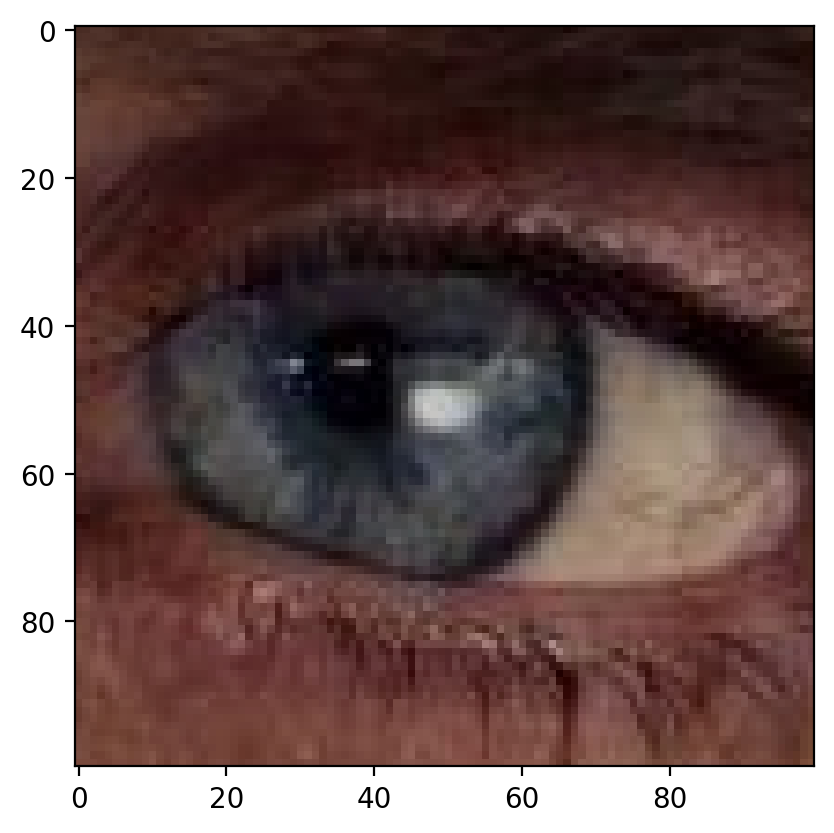

In [65]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 845, 910, 100, 100)
crop.shape
crop.to(device)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [66]:
# import random 
np.random.seed(42)

height, width = crop.shape[1:]

# Total number of pixels
total_pixels = height * width

N = 900  # Adjust this based on your needs
mask = np.ones(crop.shape[1:], dtype=bool)

# # Generate random indices for the pixels to be removed
random_pixels = random.sample(range(total_pixels), N)

random_pixels.sort()
# random_pixels


In [67]:
crop_modified = crop.clone()
# Convert the 1D indices to 2D coordinates and set them to white

for pixel in random_pixels:
    x = pixel // width  # Row index
    y = pixel % width   # Column index
    
    # Set the pixel to white
    if crop.ndim == 3:  # For RGB images
        mask[x,y] = False
        crop_modified[0,x,y] = np.nan
        crop_modified[1,x,y] = np.nan
        crop_modified[2,x,y] = np.nan
        

# Convert the NumPy array back to a PIL image
# modified_image = Image.fromarray(image_array)

# Save or display the modified image
# modified_image.save('image_with_missing_pixel.png')
# modified_image.show()

# modified_image
# mask.shape
type(crop_modified)


torch.Tensor

In [68]:
# resized_img_tensor.shape
crop_modified.shape
crop

tensor([[[0.2824, 0.2902, 0.3137,  ..., 0.1882, 0.2078, 0.2157],
         [0.2980, 0.3059, 0.3020,  ..., 0.1725, 0.2039, 0.2039],
         [0.3098, 0.3137, 0.3020,  ..., 0.1373, 0.1255, 0.1255],
         ...,
         [0.4667, 0.4588, 0.4588,  ..., 0.3529, 0.4157, 0.4392],
         [0.4784, 0.4706, 0.4314,  ..., 0.3804, 0.4196, 0.4510],
         [0.4706, 0.4667, 0.4667,  ..., 0.3882, 0.4706, 0.4902]],

        [[0.1686, 0.1765, 0.2000,  ..., 0.1176, 0.1333, 0.1412],
         [0.1843, 0.1922, 0.1882,  ..., 0.1020, 0.1294, 0.1294],
         [0.1961, 0.2000, 0.1882,  ..., 0.0667, 0.0510, 0.0510],
         ...,
         [0.2941, 0.2863, 0.2784,  ..., 0.1961, 0.2510, 0.2784],
         [0.3059, 0.2980, 0.2510,  ..., 0.2157, 0.2588, 0.2824],
         [0.2902, 0.2863, 0.2784,  ..., 0.2196, 0.2941, 0.3137]],

        [[0.1373, 0.1451, 0.1686,  ..., 0.1020, 0.1098, 0.1137],
         [0.1529, 0.1608, 0.1569,  ..., 0.0863, 0.1059, 0.1020],
         [0.1647, 0.1686, 0.1569,  ..., 0.0510, 0.0275, 0.

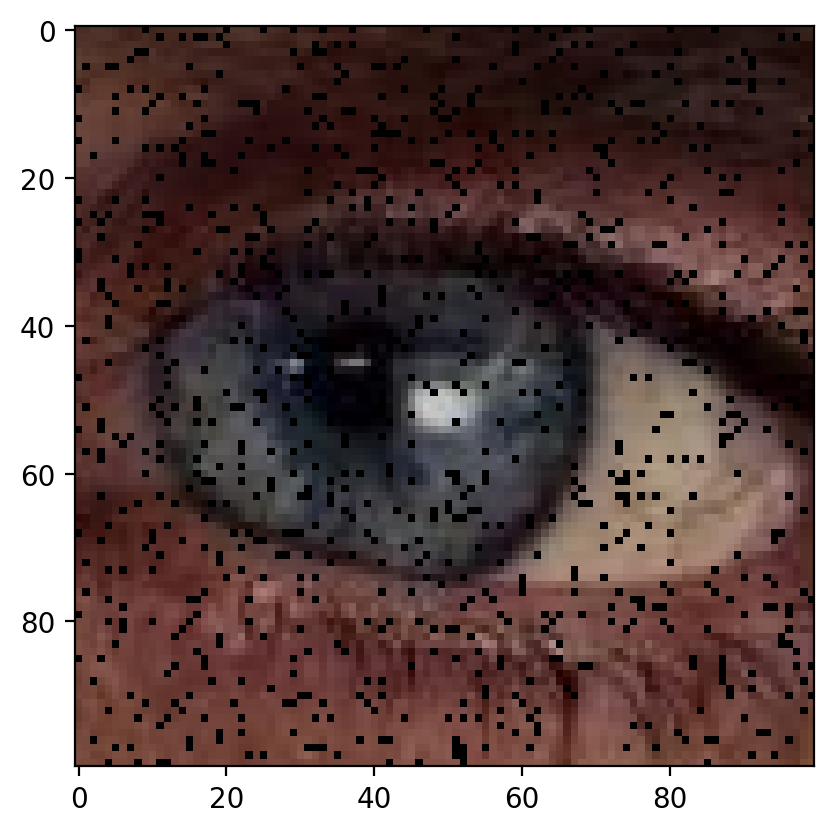

In [69]:
# plt.imshow(rearrange(resized_img_tensor, 'c h w -> h w c').cpu().numpy())
plt.imshow(rearrange(crop_modified, 'c h w -> h w c').cpu().numpy())


Suppose above is the given image to us with NAN   
We need to get the RFF for this image  
But the problem is how are the missing values be participating 

We can create mask to remove the contribution of missing pixel  
but to remove the missing pixels contribution from RFF, we need to generate RFF first  

RFF cannot be generated if nan values are present  
So, we have to approximate for the Nan value to extract the RFF  
Then we can remove the rows pertaining to the missing values  

Then we can train the model  

The below section deals with processing the missing pixel image  
Im using Gaussian blur to account for the missing pixel  
In the average, only those pixels are participating which are not nan

In [70]:
crop_modified2 = rearrange(crop_modified, 'c h w -> h w c').cpu()


In [71]:
import torch
import torch.nn.functional as F

def gaussian_filter(kernel_size=3, sigma=1.0, dtype=torch.float32):
    """Creates a 2D Gaussian kernel."""
    coords = torch.arange(kernel_size, dtype=dtype) - (kernel_size - 1) / 2.0
    grid = torch.stack(torch.meshgrid(coords, coords), dim=-1)
    gaussian_kernel = torch.exp(-(grid ** 2).sum(dim=-1) / (2 * sigma ** 2))
    gaussian_kernel /= gaussian_kernel.sum()  # Normalize the kernel to sum to 1
    return gaussian_kernel


def nan_gaussian_smoothing(image, kernel_size=3, sigma=1.0):
    """
    Replace NaN values in the image with a Gaussian average of neighboring pixels.
    
    :param image: Input image tensor (H, W) or (H, W, C)
    :param kernel_size: Size of the Gaussian kernel (odd integer)
    :param sigma: Standard deviation for the Gaussian kernel
    :return: Image tensor with NaN values replaced
    """
    dtype = torch.float32  # Use float32 consistently

    # Ensure the image is in float32
    image = image.to(dtype)

    # Create a mask of NaN values
    nan_mask = torch.isnan(image)

    # Replace NaN values temporarily with 0 for filtering
    image_temp = torch.where(nan_mask, torch.tensor(0.0, dtype=image.dtype), image)

    # Generate a 2D Gaussian filter
    kernel = gaussian_filter(kernel_size=kernel_size, sigma=sigma, dtype=dtype)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)  # Reshape to 4D for convolution

    # If the image has multiple channels (RGB), apply Gaussian filtering to each channel
    if image.dim() == 3:  # (H, W, C) format
        smoothed_image = torch.zeros_like(image)
        for c in range(image.shape[2]):
            # Extract the c-th channel and apply Gaussian filter
            channel = image_temp[:, :, c].unsqueeze(0).unsqueeze(0)  # Shape (1, 1, H, W)
            smoothed_channel = F.conv2d(channel, kernel, padding=kernel_size//2).squeeze()

            # Apply Gaussian filter to the mask (to know how many valid neighbors contribute)
            mask_channel = (~nan_mask[:, :, c]).float().unsqueeze(0).unsqueeze(0)
            mask_sum = F.conv2d(mask_channel, kernel, padding=kernel_size//2).squeeze()

            # Compute Gaussian average, ensuring to divide by the valid neighbor sum
            smoothed_image[:, :, c] = torch.where(nan_mask[:, :, c], smoothed_channel / (mask_sum + 1e-8), image[:, :, c])
    # else:  # Grayscale image (H, W) format
    #     # Apply Gaussian filter to the image
    #     image_temp = image_temp.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, H, W)
    #     smoothed_image = F.conv2d(image_temp, kernel, padding=kernel_size//2).squeeze()

    #     # Apply Gaussian filter to the mask (to know how many valid neighbors contribute)
    #     mask_temp = (~nan_mask).float().unsqueeze(0).unsqueeze(0)  # Shape (1, 1, H, W)
    #     mask_sum = F.conv2d(mask_temp, kernel, padding=kernel_size//2).squeeze()

    #     # Compute Gaussian average, ensuring to divide by the valid neighbor sum
    #     smoothed_image = torch.where(nan_mask, smoothed_image / (mask_sum + 1e-8), image)

    return smoothed_image


In [72]:
np.random.seed(42)

# Create a random RGB image (100x100) with some NaN values

# Apply NaN Gaussian smoothing with kernel size 5 and sigma 1.0
smoothed_image = nan_gaussian_smoothing(crop_modified2, kernel_size=3, sigma=1.0)

# smoothed_image now contains the image with NaN values replaced
print(smoothed_image)


tensor([[[0.2824, 0.1686, 0.1373],
         [0.2902, 0.1765, 0.1451],
         [0.3137, 0.2000, 0.1686],
         ...,
         [0.1882, 0.1176, 0.1020],
         [0.2078, 0.1333, 0.1098],
         [0.2157, 0.1412, 0.1137]],

        [[0.2980, 0.1843, 0.1529],
         [0.3059, 0.1922, 0.1608],
         [0.3020, 0.1882, 0.1569],
         ...,
         [0.1661, 0.0971, 0.0805],
         [0.2039, 0.1294, 0.1059],
         [0.2039, 0.1294, 0.1020]],

        [[0.3098, 0.1961, 0.1647],
         [0.3137, 0.2000, 0.1686],
         [0.3020, 0.1882, 0.1569],
         ...,
         [0.1373, 0.0667, 0.0510],
         [0.1255, 0.0510, 0.0275],
         [0.1255, 0.0510, 0.0235]],

        ...,

        [[0.4667, 0.2941, 0.2510],
         [0.4588, 0.2863, 0.2353],
         [0.4588, 0.2784, 0.2275],
         ...,
         [0.3529, 0.1961, 0.1490],
         [0.4157, 0.2510, 0.1882],
         [0.4392, 0.2784, 0.2000]],

        [[0.4784, 0.3059, 0.2627],
         [0.4706, 0.2980, 0.2471],
         [0.

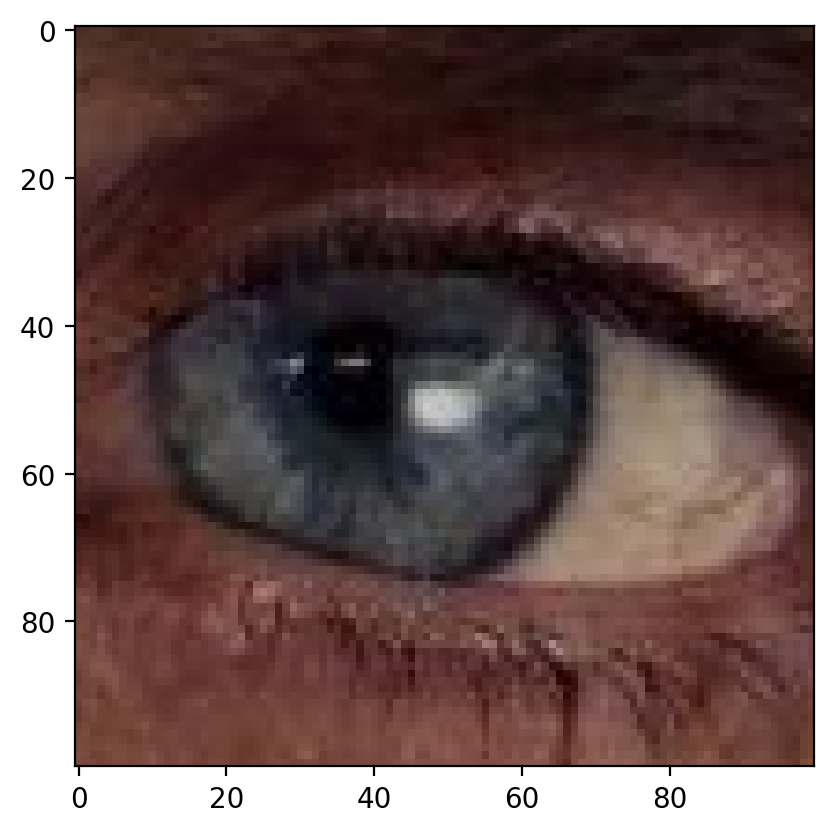

In [73]:
plt.imshow(smoothed_image.cpu().numpy())

Now we got the image. This is our input image to RBF sampler  
And we got the mask as well  

In [74]:
smoothed_image.shape

torch.Size([100, 100, 3])

In [75]:
img100 = rearrange(smoothed_image, 'h w c -> (h w) c').float()
resized_img_tensor = rearrange(smoothed_image, 'h w c ->  c h w').float()

# type(img100)
# type(smoothed_image)
# smoothed_image

reshape image tensor to 1D, remove nan points

In [77]:
np.random.seed(42)

img9100 = crop_modified2.clone()

img9100 = rearrange(img9100, 'h w c -> (h w) c').float()
k = ~torch.isnan(img9100)

img_not_nan = torch.randn(9100, 3)

j = 0
for i in range(10000):
    if k[i][0] == True :
        img_not_nan[j] = img9100[i]
        j = j+1


img_not_nan
# img9100

tensor([[0.2824, 0.1686, 0.1373],
        [0.2902, 0.1765, 0.1451],
        [0.3137, 0.2000, 0.1686],
        ...,
        [0.3882, 0.2196, 0.1569],
        [0.4706, 0.2941, 0.2196],
        [0.4902, 0.3137, 0.2314]])

In [78]:
mask2 = mask.flatten().reshape(-1, 1)

mask2.shape

(10000, 1)

In [79]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [80]:
def create_rff_features(X, num_features, sigma):
    
    from sklearn.kernel_approximation import RBFSampler
    
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    
    return torch.tensor(X, dtype=torch.float32).to(device)

In [81]:
def train(net, lr, X, Y, epochs, batch_size=32, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    epochs: int
    batch_size: int, default=32
    verbose: bool, default=True
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(num_batches):
            optimizer.zero_grad()
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_X = X[start_idx:end_idx]
            batch_Y = Y[start_idx:end_idx]
            outputs = net(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {running_loss / num_batches:.6f}")


In [82]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0,width).repeat(height, 1)
    h_coords = torch.arange(0,height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [83]:
print(resized_img_tensor.shape)
type(resized_img_tensor[0])

torch.Size([3, 100, 100])


torch.Tensor

In [84]:
img_X,img_Y=create_coordinate_map(resized_img_tensor)
print(img_X.shape)
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinaimg
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()
print(img_X_scaled.shape)

torch.Size([10000, 2])
torch.Size([10000, 2])


In [85]:
len(mask2)
not_nan_num = N 
N

900

In [134]:
feature = 8750
mask_size = len(mask2)
new_img_size = mask_size - not_nan_num

X_rff = create_rff_features(img_X_scaled, feature, 0.008)
print(X_rff.shape)


torch.Size([10000, 8750])


In [135]:
np.random.seed(42)


X_rff=X_rff.cpu().numpy()
X_final = np.random.random((new_img_size, feature))

j = 0
for i in range(mask_size):
  if i in random_pixels :
    pass 
  else :
    X_final[j]=X_rff[i]
    j=j+1
    
X_rff=torch.tensor(X_rff,dtype=torch.float32).to(device)

X_final=torch.tensor(X_final,dtype=torch.float32).to(device)

net = LinearModel(X_final.shape[1], 3)
net.to(device)

resized_= torch.tensor(img_not_nan,dtype=torch.float32).to(device)
resized_.shape

torch.Size([9100, 3])

In [136]:
train(net, 0.005, X_final, resized_, 1000,100,True)


Epoch 0 loss: 0.019984
Epoch 100 loss: 0.002960
Epoch 200 loss: 0.002379
Epoch 300 loss: 0.002125
Epoch 400 loss: 0.001839
Epoch 500 loss: 0.001694
Epoch 600 loss: 0.001590
Epoch 700 loss: 0.001496
Epoch 800 loss: 0.001520
Epoch 900 loss: 0.001399


In [137]:
# X_rff.shape
# X_final.shape
net

LinearModel(
  (linear): Linear(in_features=8750, out_features=3, bias=True)
)

In [138]:
# with torch.no_grad():
#         outputs = net(X_final)
#         outputs = outputs.reshape(91,100,3)
# plt.imshow(outputs.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


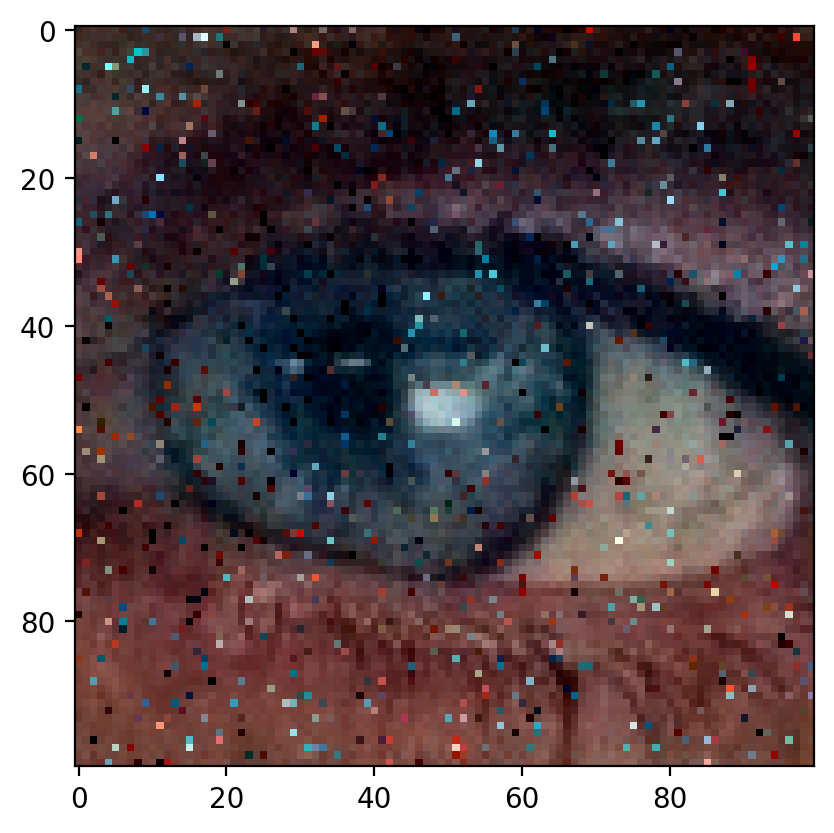

In [139]:

with torch.no_grad():
      outputs = net(X_rff)[:10000]
      outputs = outputs.reshape(100, 100 , 3)
plt.imshow(outputs.cpu())

In [140]:
def plot_reconstructed_and_original_image_RFF(original_img, net, X, X_trained, image_with_nan, maskedImage, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs_train = net(X_trained)
        outputs = outputs.reshape(100, 100, 3)
        outputs_train = outputs_train.reshape(91, 100, 3)
        
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    
    ax0.set_title("Original Image")
    ax0.imshow(original_img.cpu().permute(1, 2, 0))
    
    ax2.set_title("Missing pixels")
    ax2.imshow(image_with_nan.cpu().permute(1, 2, 0))
    
    
    ax1.set_title(" smoothened")
    #ax1.imshow(maskedImage.reshape(200,200,3).cpu().numpy())
    ax1.imshow(rearrange(maskedImage, 'c h w -> h w c').cpu().numpy())
    
    # ax3.set_title(f" 91*100")
    # ax3.imshow(outputs_train.cpu())
    
    ax3.set_title(f" 100*100")
    ax3.imshow(outputs.cpu())
    
    squared_error = torch.square(outputs.cpu() - original_img.cpu().permute(1,2,0))
    mse = torch.mean(squared_error)
    rmse = torch.sqrt(mse)
    max_val = 1.0
    psnr = 10 * torch.log10(max_val / rmse)
    print(f"With reconstructed image: RMSE: {rmse}, PSNR: {psnr} \n")
    
    ####################################################################3
    
# Calculate the PSNR
    for a in [ax0, ax1, ax2, ax3]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


With smoothened image:  RMSE: 0.007584424627844956, PSNR: 21.200773602206937 

With reconstructed image: RMSE: 0.09901790215989169, PSNR: 10.042862790753706 



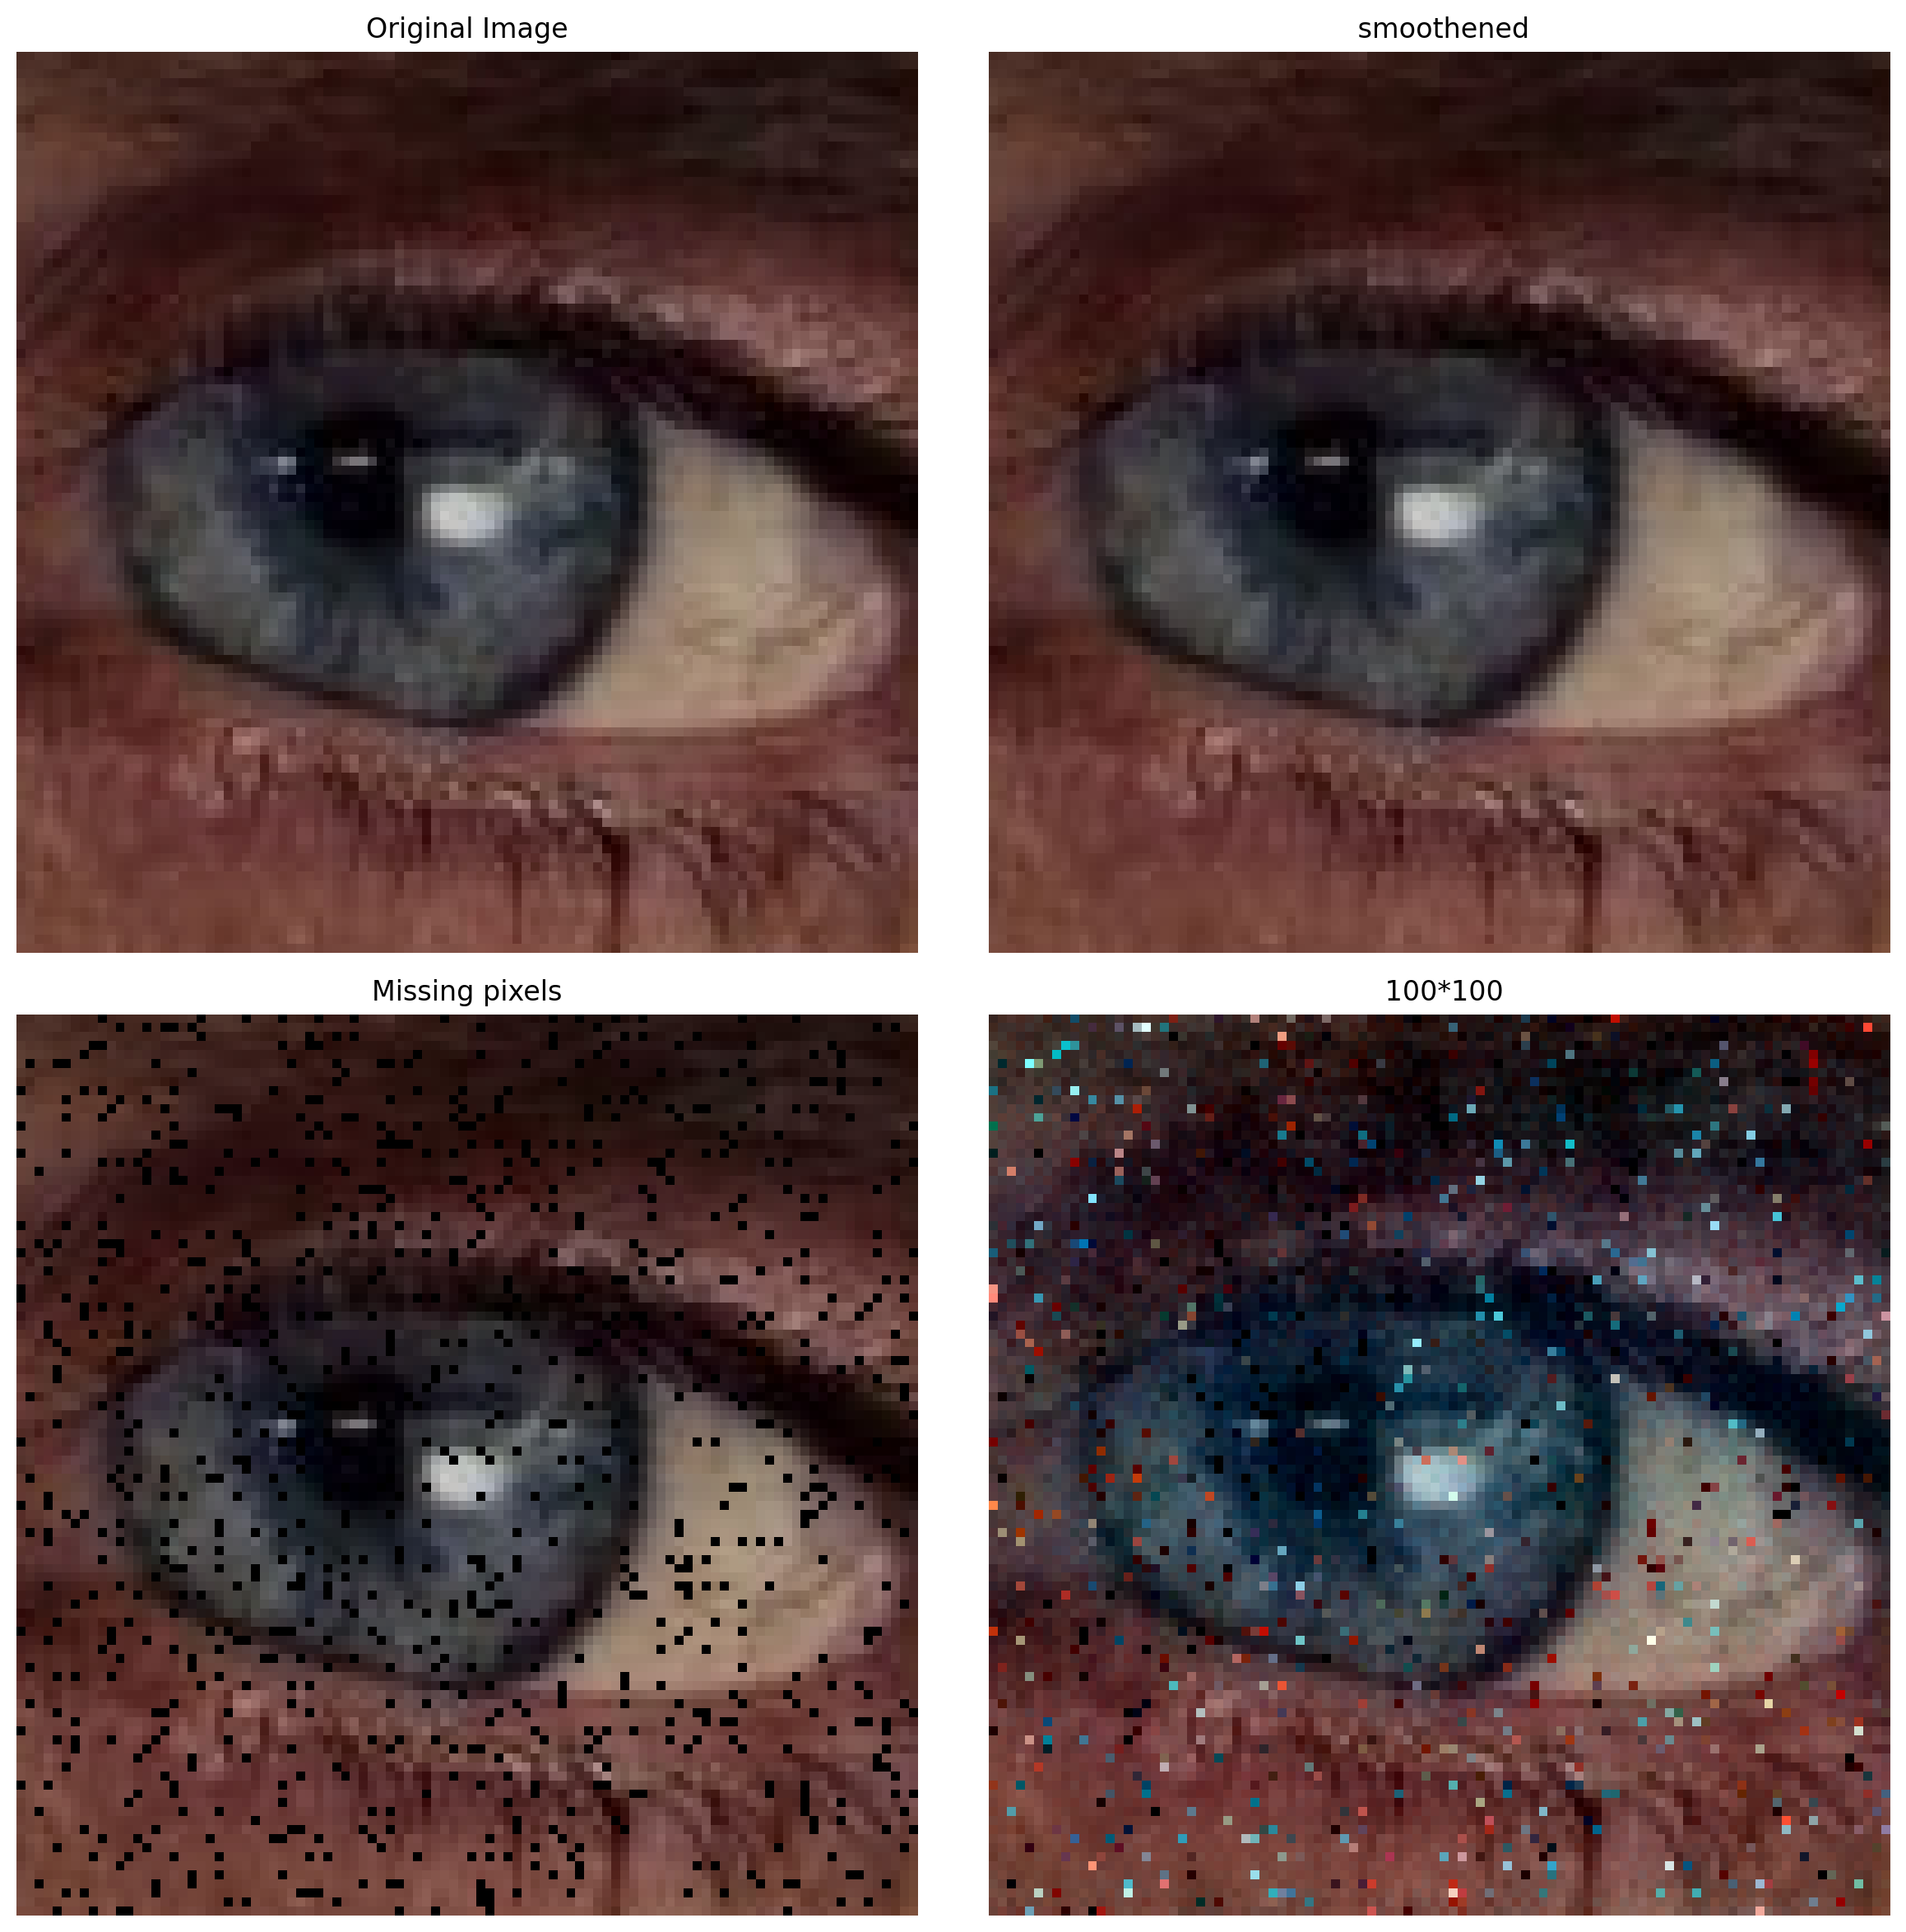

In [141]:
squared_error = torch.square(rearrange(resized_img_tensor, 'c h w -> h w c').cpu() - crop.cpu().permute(1,2,0))
mse = torch.mean(squared_error)
rmse = torch.sqrt(mse)
max_val = 1.0
psnr = 10 * torch.log10(max_val / rmse)
print(f"With smoothened image:  RMSE: {rmse}, PSNR: {psnr} \n")


plot_reconstructed_and_original_image_RFF(crop, net, X_rff, X_final, crop_modified, resized_img_tensor)



Feature 5000  
With reconstructed image: RMSE: 0.13778245326164948, PSNR: 8.608060867597185  
With smoothened image:  RMSE: 0.007584424627844956, PSNR: 21.200773602206937  

Feature 7500  
With reconstructed image: RMSE: 0.09712686689510501, PSNR: 10.12660620448942  
With smoothened image:  RMSE: 0.007584424627844956, PSNR: 21.200773602206937 

Feature 8000  
With reconstructed image: RMSE: 0.09601402376169224, PSNR: 10.17665329486335   
With smoothened image:  RMSE: 0.007584424627844956, PSNR: 21.200773602206937  

Feature 8500  
With reconstructed image: RMSE: 0.09205983373404614, PSNR: 10.359298138049764  
With smoothened image:  RMSE: 0.007584424627844956, PSNR: 21.200773602206937   

Feature 8750  
With reconstructed image: RMSE: 0.09901790215989169, PSNR: 10.042862790753706   
With smoothened image:  RMSE: 0.007584424627844956, PSNR: 21.200773602206937   

Feature 9000  
With reconstructed image: RMSE: 0.10531809123486434, PSNR: 9.774970205655672   
With smoothened image:  RMSE: 0.007584424627844956, PSNR: 21.200773602206937   

Feature 10,000   
With reconstructed image: RMSE: 0.10591182388841903, PSNR: 9.750555529912072   
With smoothened image:  RMSE: 0.008059622739031103, PSNR: 20.936852865065223  

Feature 20,000   
With reconstructed image: RMSE: 0.1326320034595456, PSNR: 8.773516701327853    
With smoothened image:  RMSE: 0.007694750423537324, PSNR: 21.138054617894    
   
Feature 40,000   
With reconstructed image: RMSE: 0.1967651516017631, PSNR: 7.060518154940319   
With smoothened image:  RMSE: 0.007584424627844956, PSNR: 21.200773602206937    



